In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import math

from pandas import read_csv
from scipy.optimize import curve_fit
import pickle

import czifile

In [2]:
import cv2

In [3]:
import sys
import sys
sys.path.append('../')
from inference.read_in_data import *
from inference.correlation_heatmap import *
from inference.calculating_tau import *

In [4]:
video_time_length=60 #s
imgname='GFPFUS_aged3daus_688umheight_1au'
foldername='/Volumes/wwyyrx/Wenyun/20230320/'

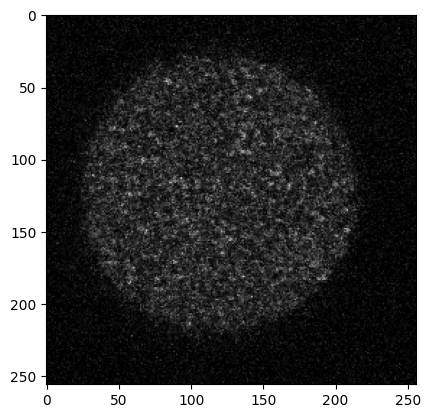

In [5]:
# Read the CZI file
data = czifile.imread(foldername+imgname+'.czi')
framespeed=video_time_length/data.shape[1]

# Display the first image in the file
plt.imshow(data[0, 0, 0, 0, :, :, 0], cmap='gray')
plt.show()

In [6]:
# apply a gaussian blur
for t in range(0,data.shape[1],1):
    data[0,t,0,0,:,:,0]=cv2.GaussianBlur(data[0,t,0,0,:,:,0], (3, 3), 1.6)

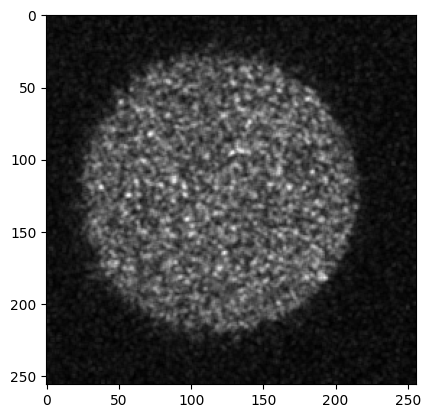

In [7]:
plt.imshow(data[0, 1, 0, 0, :, :, 0], cmap='gray')
plt.show()

In [8]:
def compute_g2t_wo_kernel(px,laglist_g2t,normalize=True,plot=False):
    intensity=[]
    for t in range(0,data.shape[1],1):
        intensity.append(data[0, t, 0, 0, px[0], px[1], 0]) #px[0]=y
        
    g2t=np.zeros(len(laglist_g2t))
    for lag in laglist_g2t:
        numerator=[]
        denumerator1=[]
        denumerator2=[]
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator.append(int(intensity[t])*int(intensity[t+lag]))
            denumerator1.append(intensity[t])
            denumerator2.append(intensity[t+lag])
        g2t[lag]=(np.array(numerator).mean()/np.array(denumerator1).mean()/np.array(denumerator2).mean())-1
        #g2t[lag]=g2t[lag]/g2t[0]
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    if plot == True:
        plt.figure(figsize=(8,5))
        plt.plot(intensity[0:200],'k-')
        plt.xlabel("Time",fontsize=18)
        plt.ylabel("Intensity",fontsize=18)
        plt.tick_params(direction='in')
    return g2t

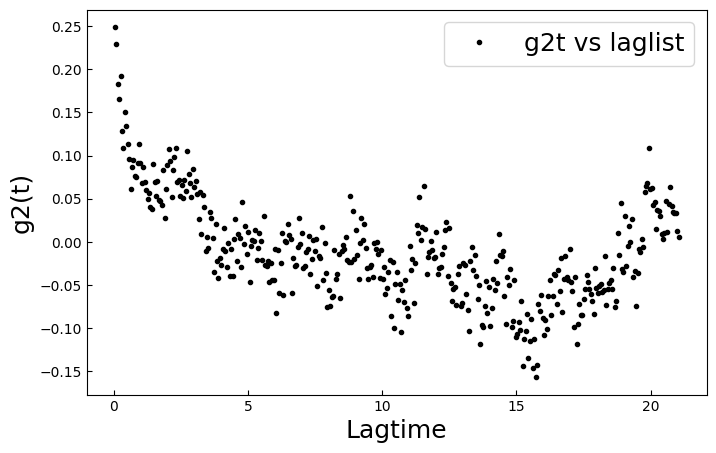

In [13]:
laglist_g2t=range(0,400,1)
px=[155,88]
g2t=compute_g2t_wo_kernel(px,laglist_g2t)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[1:],g2t[1:],'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
#plt.yscale('log')
plt.tick_params(direction='in')

tau is: 0.6254497364706092
y = -1.59885 * x + -1.37734


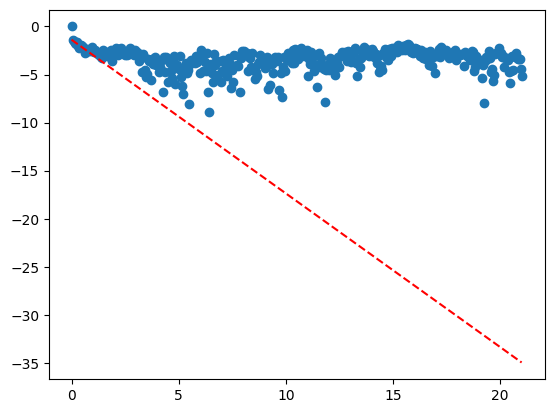

R square is 0.7033172415541581
0.6254497364706092


In [11]:
plateau=0#np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(g2t),lagtime_g2t,1,10, True)
print(tau)

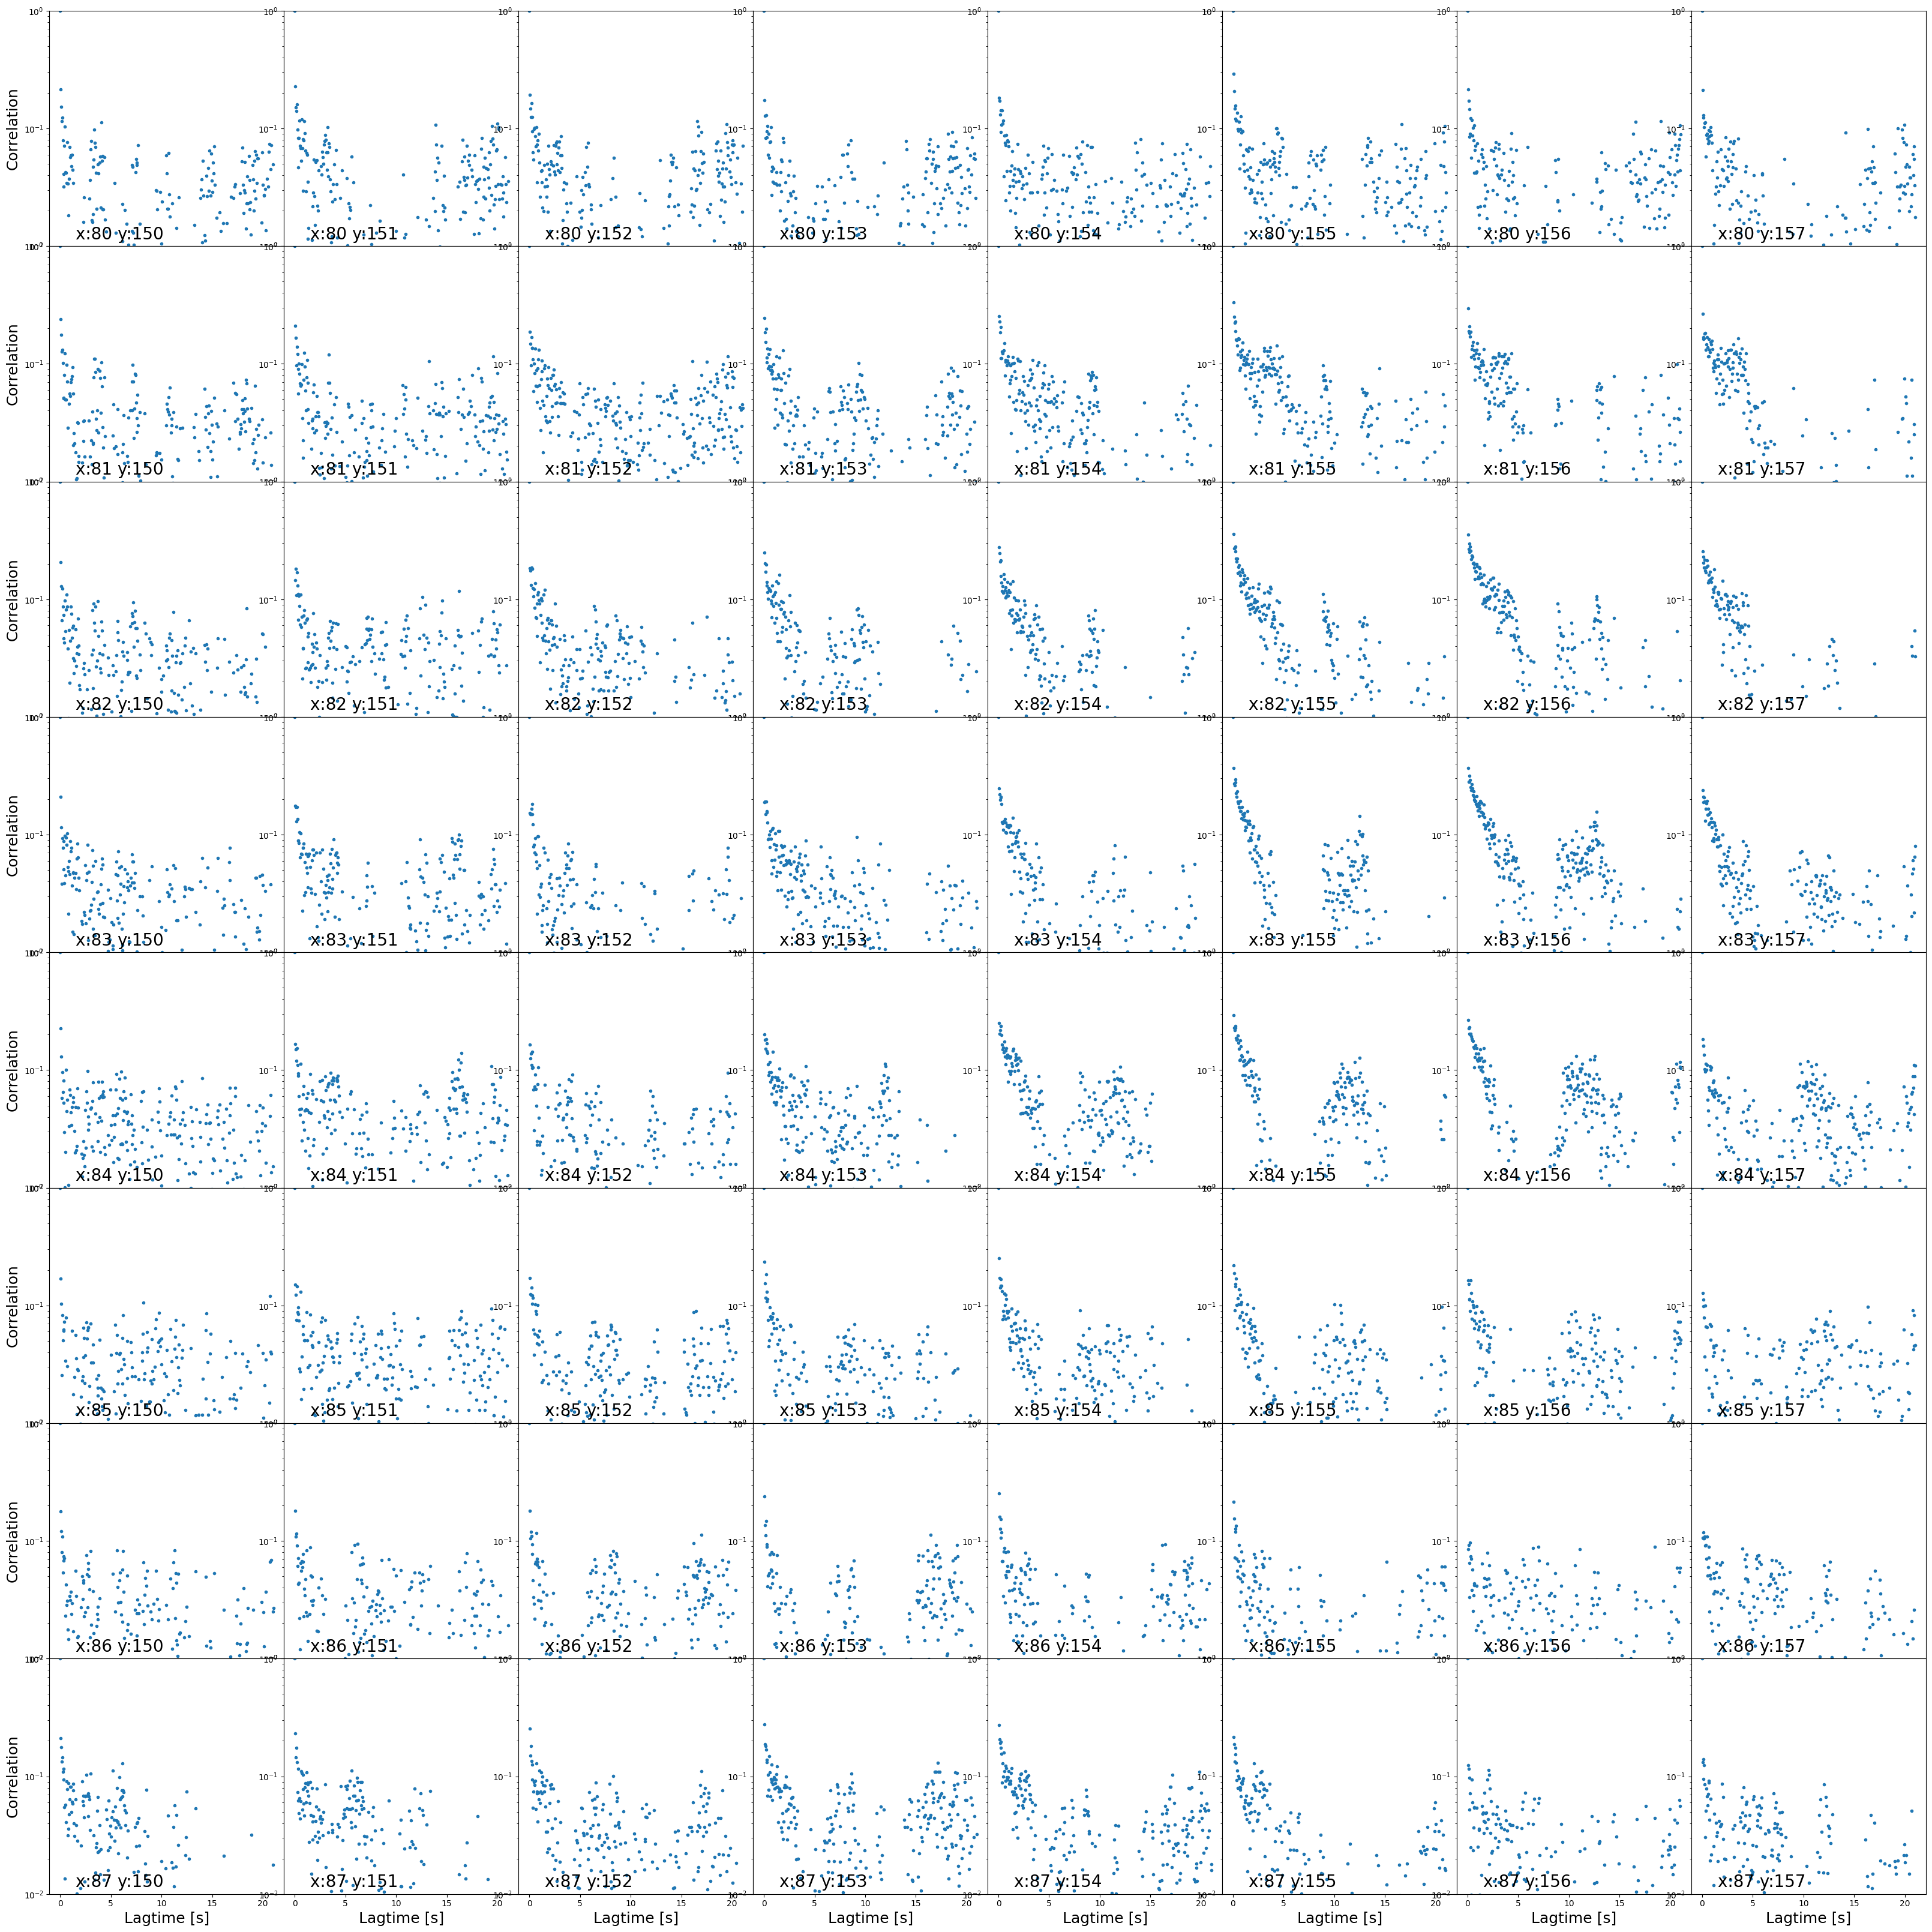

In [76]:
ncols = 8
nrows = 8
sizex = 4
sizey = 4
view_size = 1000
ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=[ncols*sizex,nrows*sizey])[1]
power=1
for x in range(ncols):
    for y in range(nrows):
        g2t=compute_g2t_wo_kernel([150+y,80+x],laglist_g2t)
        plateau=0
        average_tau = np.array(g2t)-plateau
        lagtime_fx= np.array([element * framespeed for element in laglist_g2t])
        lagtime_power=lagtime_fx**power
        ax[x,y].plot(lagtime_power,g2t,'.')
#         ax[x,y].legend(['Correlation vs Lagtime'], fontsize=18)

        ax[x,y].set_xlabel("Lagtime [s]",fontsize=18)
        if (y == 0):
            ax[x,y].set_ylabel("Correlation",fontsize=18)
        else:
            ax[x,y].set_yticklabels([])
        ax[x,y].set_ylim([0.01, 1])
        ax[x,y].set_yscale('log')
#         ax[x,y].set_ytick()

        
        ax[x,y].text(0.3,0.05,'x:'+str(80+x)+' y:'+str(150+y),horizontalalignment='center',verticalalignment='center',
                   transform=ax[x,y].transAxes, color='k',fontsize=20)
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)

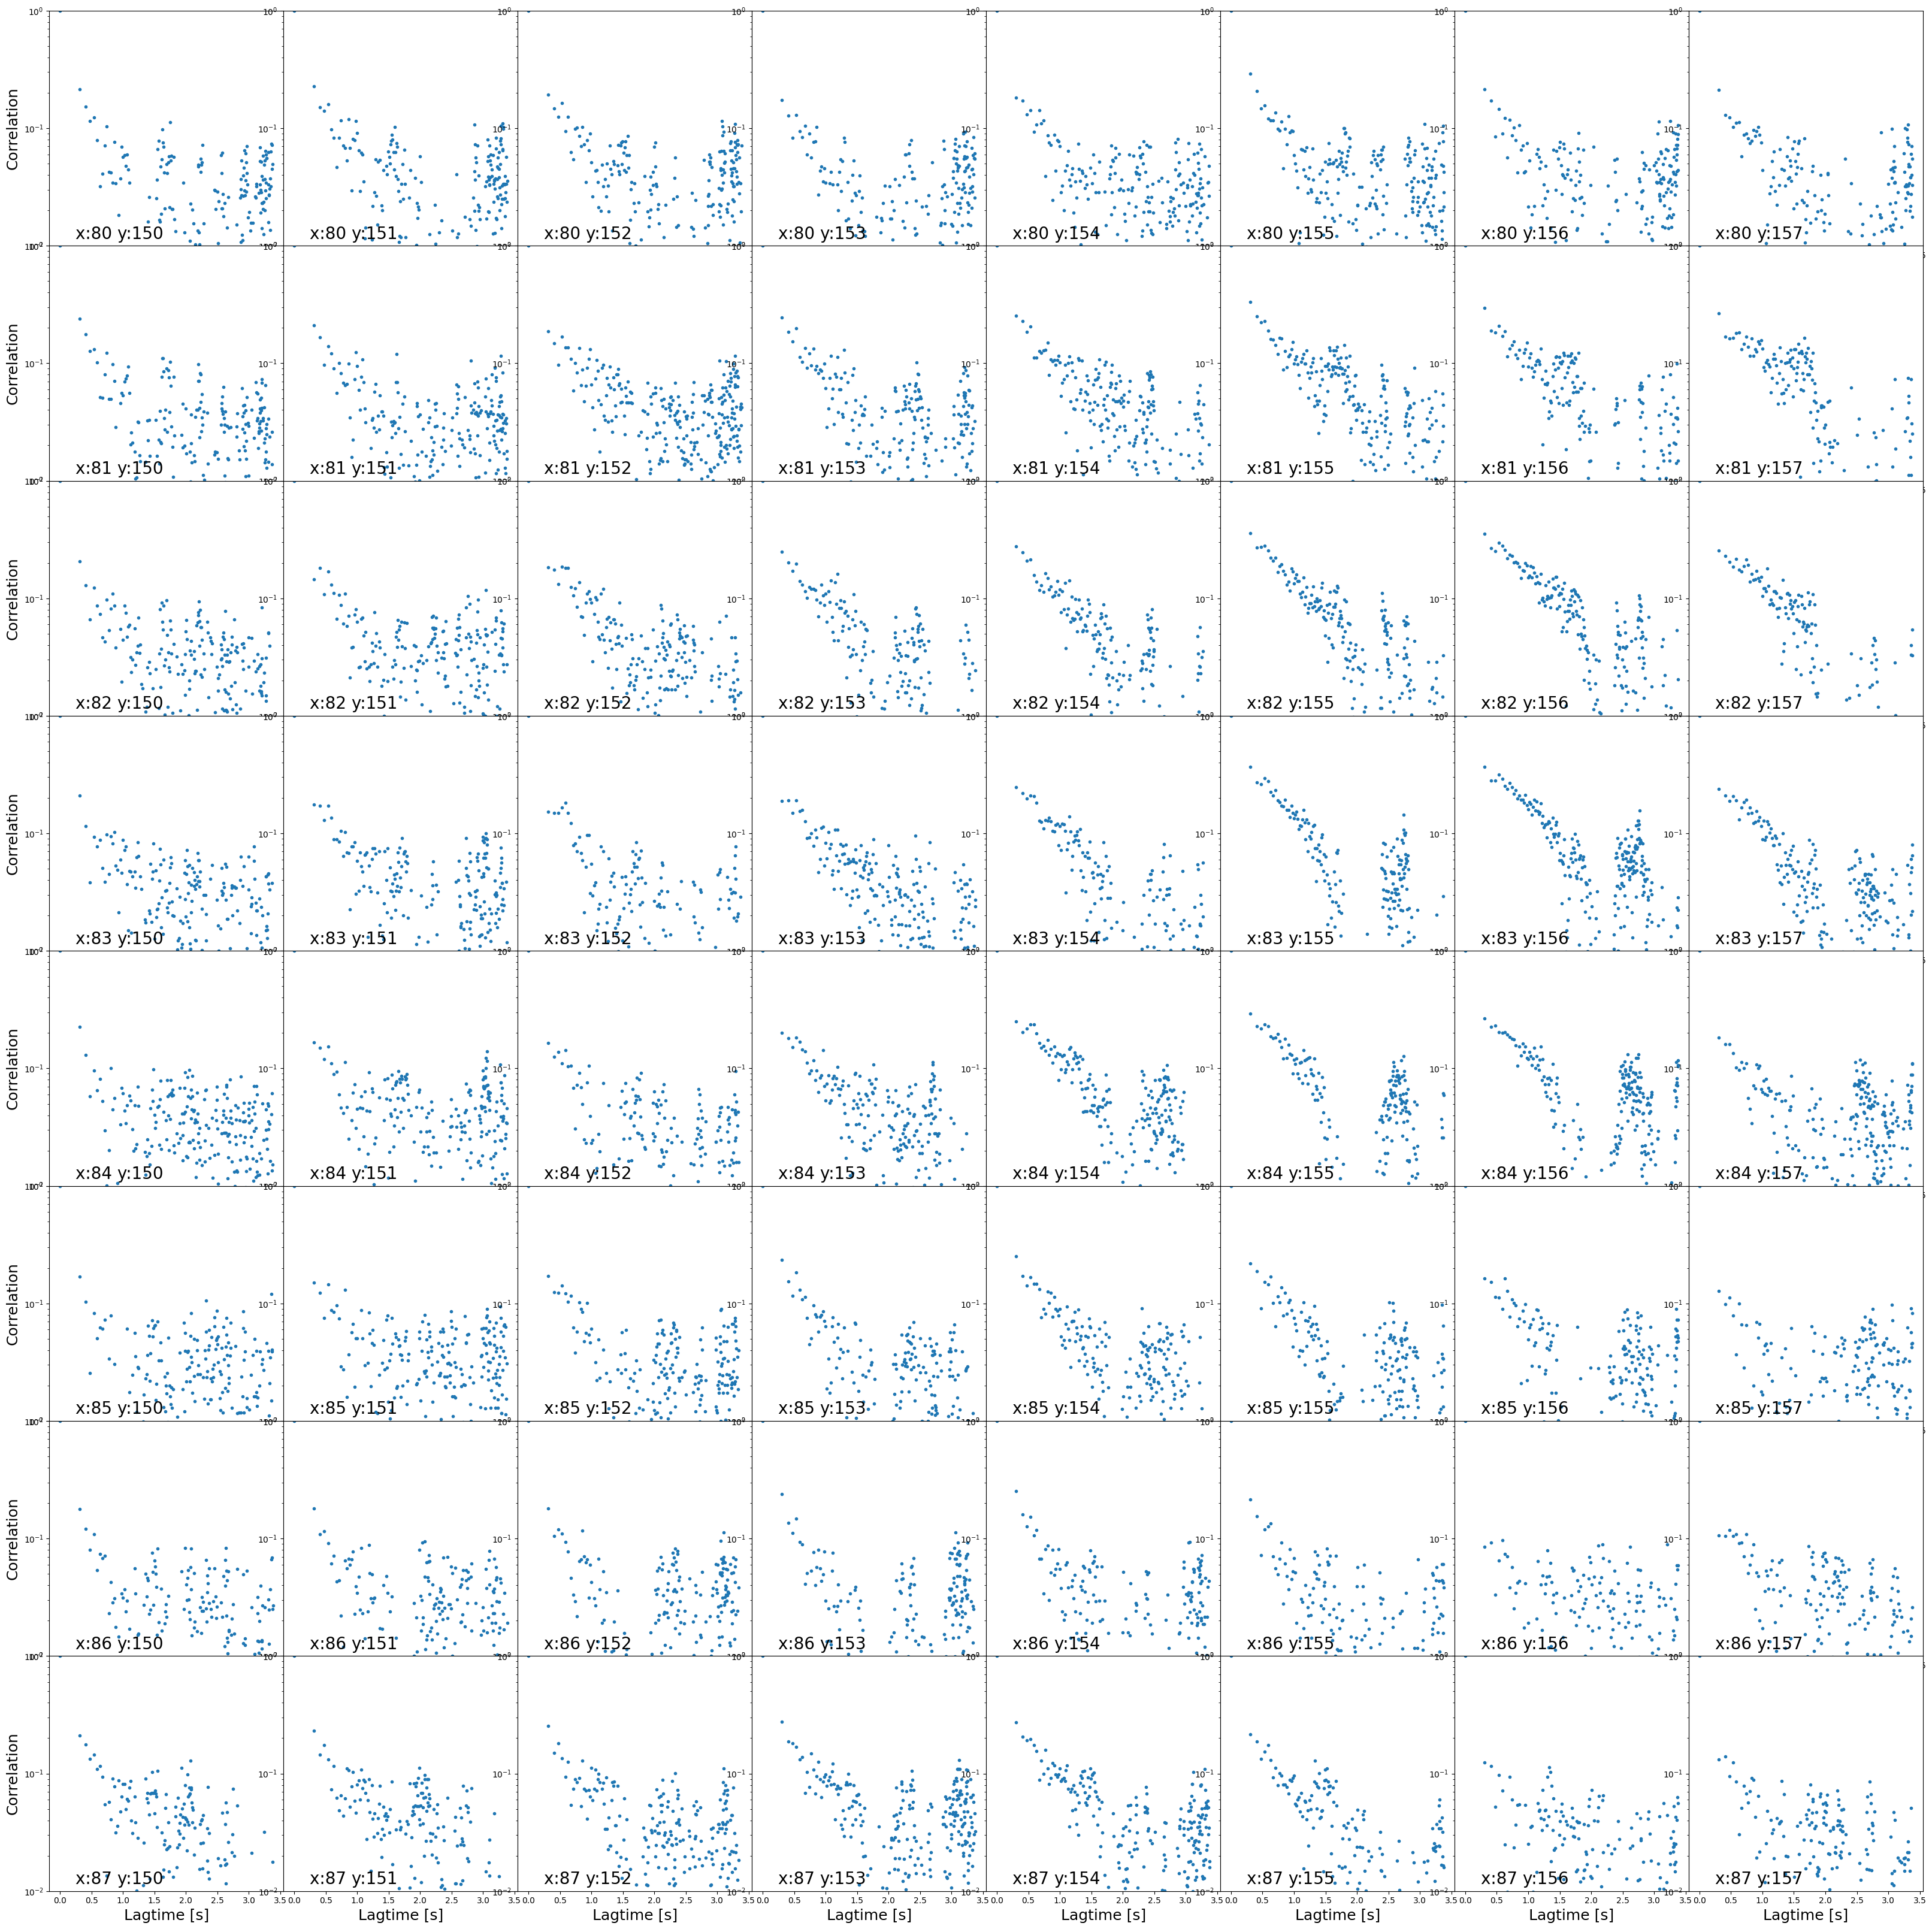

In [77]:
ncols = 8
nrows = 8
sizex = 4
sizey = 4
view_size = 1000
ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=[ncols*sizex,nrows*sizey])[1]
power=0.4
for x in range(ncols):
    for y in range(nrows):
        g2t=compute_g2t_wo_kernel([150+y,80+x],laglist_g2t)
        plateau=0
        average_tau = np.array(g2t)-plateau
        lagtime_fx= np.array([element * framespeed for element in laglist_g2t])
        lagtime_power=lagtime_fx**power
        ax[x,y].plot(lagtime_power,g2t,'.')
#         ax[x,y].legend(['Correlation vs Lagtime'], fontsize=18)

        ax[x,y].set_xlabel("Lagtime [s]",fontsize=18)
        if (y == 0):
            ax[x,y].set_ylabel("Correlation",fontsize=18)
        else:
            ax[x,y].set_yticklabels([])
        ax[x,y].set_ylim([0.01, 1])
        ax[x,y].set_yscale('log')
#         ax[x,y].set_ytick()

        
        ax[x,y].text(0.3,0.05,'x:'+str(80+x)+' y:'+str(150+y),horizontalalignment='center',verticalalignment='center',
                   transform=ax[x,y].transAxes, color='k',fontsize=20)
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)

In [9]:
def fit_streched_exponential_decay(noise,average_tau,laglist_fx,startidx,endidx,power=0.4):
    lagtime_fx= np.array([element * framespeed for element in laglist_fx])
    lagtime_power=lagtime_fx**power
#noise=np.mean(average_tau[850:900])
    load_correlation=average_tau
    substracted_correlation=average_tau-noise
# plt.subplot(1, 2, 1)
# #     plt.figure(figsize=(10,10))
# plt.plot(lagtime,average_tau,'_')

#log_laglist=np.zeros(250)
    log_correlation=np.zeros(len(lagtime_fx))
    log_correlation_s=np.zeros(len(lagtime_fx))
    for i in range(len(laglist_fx)):
    #log_laglist[i]=math.log(laglist[i])
        log_correlation[i]=math.log(abs(load_correlation[i]))
        log_correlation_s[i]=math.log(abs(substracted_correlation[i]))

    x, y = lagtime_power[startidx:endidx], log_correlation_s[startidx:endidx]
    # curve fit
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b = popt

    return -1/a

In [10]:
objective

<function inference.calculating_tau.objective(x, a, b)>

In [12]:
heatmap_decay_streched_decay = np.zeros((100, 100))
for y in range(0,100,1):
    for x in range(0,100,1):
        px=[y,x]
        print(px)
        g2t=compute_g2t_wo_kernel([70+y,70+x],laglist_g2t)
        plateau=0
        startidx_fast=1
        endidx_fast=7
        temp=fit_streched_exponential_decay(plateau,g2t,laglist_g2t,startidx_fast,endidx_fast)
        inverse_power=1/0.4
        heatmap_decay_streched_decay[px[0],px[1]]=temp**inverse_power
        print(heatmap_decay_streched_decay[px[0],px[1]])

[0, 0]


NameError: name 'laglist_g2t' is not defined

<AxesSubplot: >

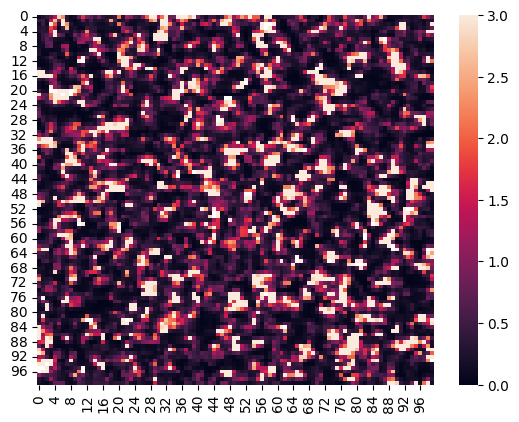

In [15]:
sns.heatmap(heatmap_decay_streched_decay,vmin=0,vmax=3)

In [19]:
pickle.dump(heatmap_decay_streched_decay, open(foldername+imgname+"tau_heatmap_whole.p", "wb"))

In [ ]:
heatmap_decay_streched_decay[10,20]

10.152532489460327

In [14]:
def fit_streched_exponential_decay_plot(noise,average_tau,laglist_fx,startidx,endidx,power=0.4):
    lagtime_fx= np.array([element * framespeed for element in laglist_fx])
    lagtime_power=lagtime_fx**power
    load_correlation=average_tau
    substracted_correlation=average_tau-noise

    log_correlation=np.zeros(len(lagtime_fx))
    log_correlation_s=np.zeros(len(lagtime_fx))
    for i in range(len(laglist_fx)):
    #log_laglist[i]=math.log(laglist[i])
        log_correlation[i]=math.log(abs(load_correlation[i]))
        log_correlation_s[i]=math.log(abs(substracted_correlation[i]))

    x, y = lagtime_power, log_correlation_s
    # curve fit
    popt, _ = curve_fit(objective, x[startidx:endidx], y[startidx:endidx])
    # summarize the parameter values
    a, b = popt
    print((-1/a)**2.5)
    print('y = %.5f * x + %.5f' % (a, b))
    # plot input vs output
    plt.scatter(x, y)
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 1)
    # calculate the output for the range
    y_line = objective(x_line, a, b)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color='red')
    plt.show()
    return -1/a,a,b

[10, 20]
0.1674830120547223
y = -2.04367 * x + -0.95369


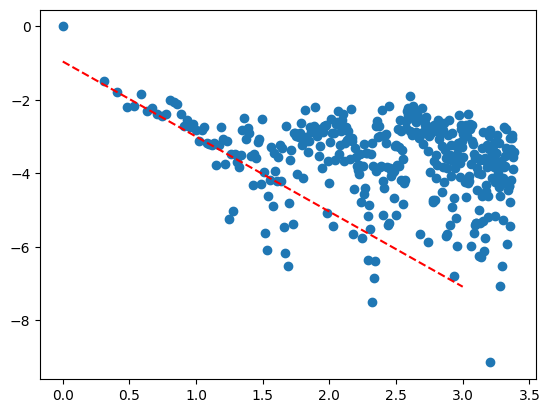

In [ ]:
px=[10,20]
print(px)
g2t=compute_g2t_wo_kernel([70+y,70+x],laglist_g2t)
plateau=0
startidx_fast=1
endidx_fast=7
temp=fit_streched_exponential_decay_plot(plateau,g2t,laglist_g2t,startidx_fast,endidx_fast)

# Sanity checks:
## split videos into two

In [15]:
def compute_g2t_wo_kernel_given_intensity_range(px,laglist_g2t,intensity_range,normalize=True,plot=False):
    intensity=[]
    for t in intensity_range:
        intensity.append(data[0, t, 0, 0, px[0], px[1], 0]) #px[0]=y
        
    g2t=np.zeros(len(laglist_g2t))
    for lag in laglist_g2t:
        numerator=[]
        denumerator1=[]
        denumerator2=[]
        max_t_range=len(intensity)-lag
        for t in range(0,max_t_range,1):
            numerator.append(int(intensity[t])*int(intensity[t+lag]))
            denumerator1.append(intensity[t])
            denumerator2.append(intensity[t+lag])
        g2t[lag]=(np.array(numerator).mean()/np.array(denumerator1).mean()/np.array(denumerator2).mean())-1
        #g2t[lag]=g2t[lag]/g2t[0]
    if normalize:
        first=g2t[0]
        for lag in laglist_g2t:
            g2t[lag]=g2t[lag]/first
    if plot == True:
        plt.figure(figsize=(8,5))
        plt.plot(intensity[0:200],'k-')
        plt.xlabel("Time",fontsize=18)
        plt.ylabel("Intensity",fontsize=18)
        plt.tick_params(direction='in')
    return g2t

In [16]:
laglist_g2t=range(0,200,1)

TypeError: 'int' object is not iterable

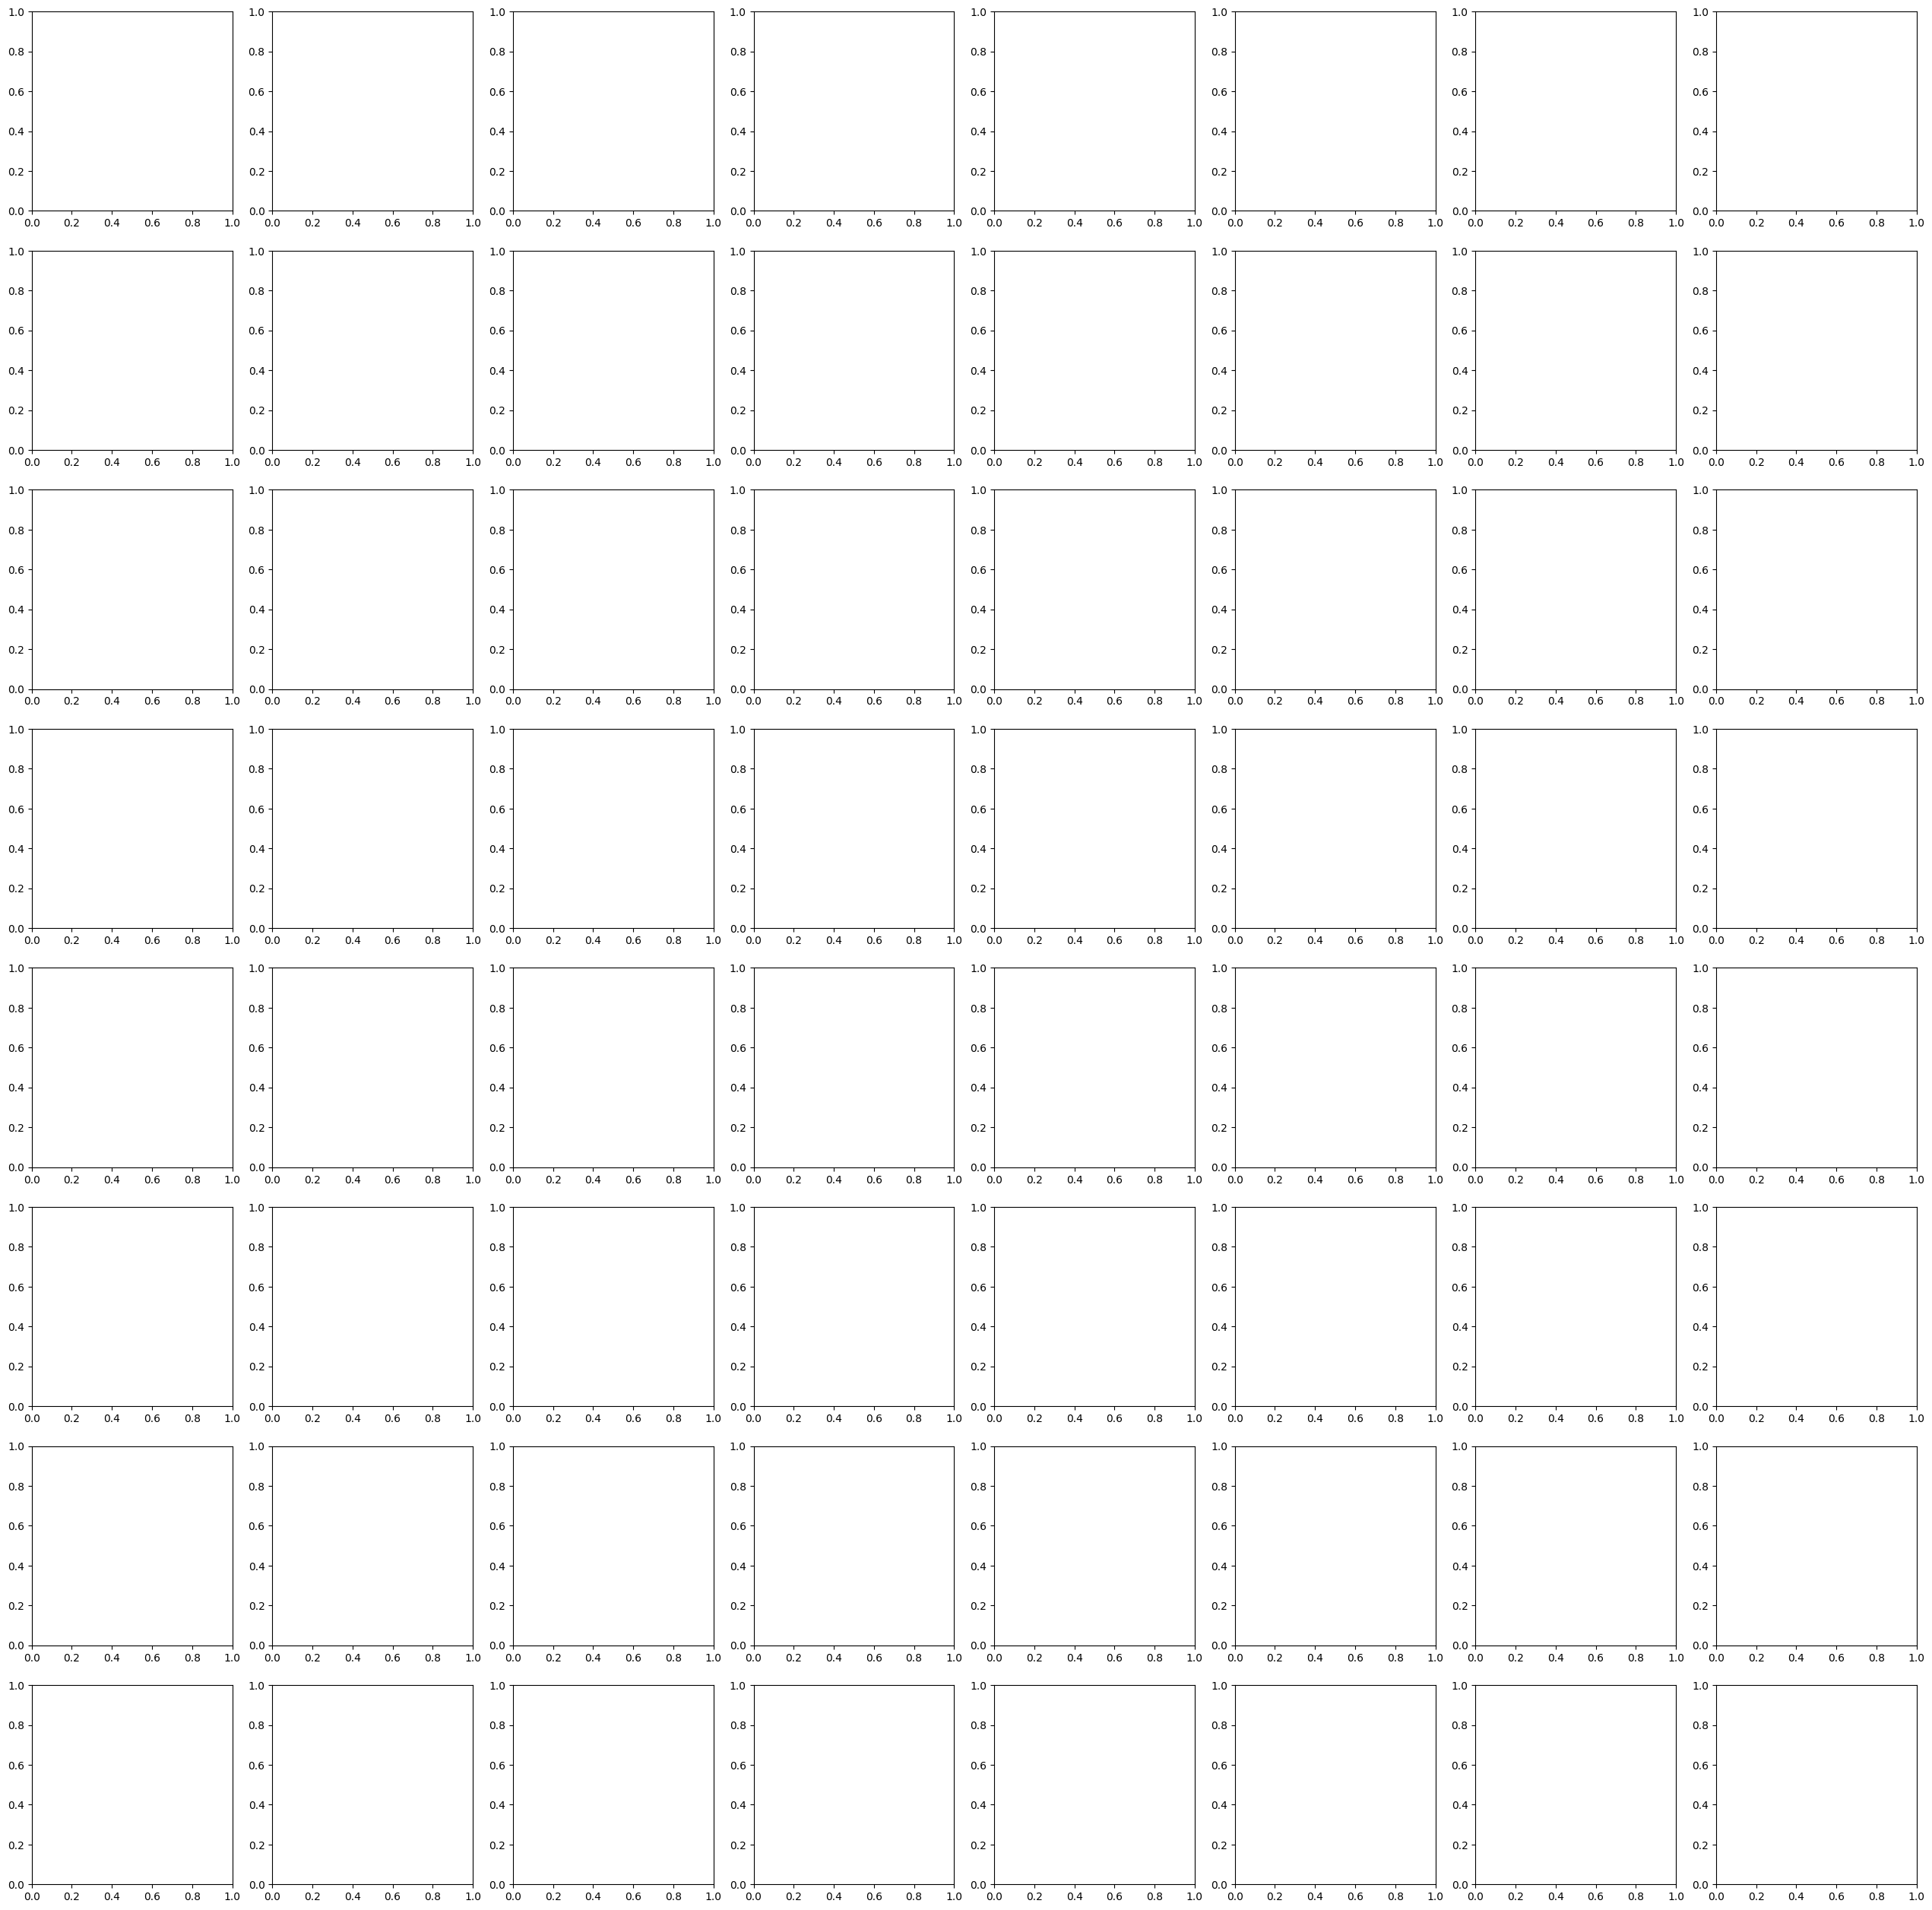

In [25]:
ncols = 8
nrows = 8
sizex = 4
sizey = 4
view_size = 1000
ax = plt.subplots(ncols = ncols, nrows = nrows, figsize=[ncols*sizex,nrows*sizey])[1]
power=0.4
for x in range(ncols):
    for y in range(nrows):
        g2t=compute_g2t_wo_kernel_given_intensity_range([150+y,80+x],laglist_g2t,data.shape[1]//2)
        plateau=0
        average_tau = np.array(g2t)-plateau
        lagtime_fx= np.array([element * framespeed for element in laglist_g2t])
        lagtime_power=lagtime_fx**power
        ax[x,y].plot(lagtime_power,g2t,'.')
#         ax[x,y].legend(['Correlation vs Lagtime'], fontsize=18)

        ax[x,y].set_xlabel("Lagtime [s]",fontsize=18)
        if (y == 0):
            ax[x,y].set_ylabel("Correlation",fontsize=18)
        else:
            ax[x,y].set_yticklabels([])
        ax[x,y].set_ylim([0.01, 1])
        ax[x,y].set_yscale('log')
#         ax[x,y].set_ytick()

        
        ax[x,y].text(0.3,0.05,'x:'+str(80+x)+' y:'+str(150+y),horizontalalignment='center',verticalalignment='center',
                   transform=ax[x,y].transAxes, color='k',fontsize=20)
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.0,hspace=0.0)

In [ ]:
heatmap_decay_streched_decay_firsthalfdata = np.zeros((20, 20))
for y in range(0,20,1):
    for x in range(0,20,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel_given_intensity_range([80+y,80+x],laglist_g2t,range(0,data.shape[1]//2,1))
        plateau=0
        startidx_fast=1
        endidx_fast=5
        temp=fit_streched_exponential_decay(plateau,g2t,laglist_g2t,startidx_fast,endidx_fast)
        inverse_power=1/0.4
        heatmap_decay_streched_decay_firsthalfdata[px[0],px[1]]=temp**inverse_power

/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_30790/2994928224.py:11: RuntimeWarning: invalid value encountered in scalar power
  heatmap_decay_streched_decay_firsthalfdata[px[0],px[1]]=temp**inverse_power


In [ ]:
heatmap_decay_streched_decay_secondhalfdata = np.zeros((20, 20))
for y in range(0,20,1):
    for x in range(0,20,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel_given_intensity_range([80+y,80+x],laglist_g2t,range(data.shape[1]//2,data.shape[1],1))
        plateau=0
        startidx_fast=1
        endidx_fast=7
        temp=fit_streched_exponential_decay(plateau,g2t,laglist_g2t,startidx_fast,endidx_fast)
        inverse_power=1/0.4
        heatmap_decay_streched_decay_secondhalfdata[px[0],px[1]]=temp**inverse_power

/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_30790/1706477328.py:11: RuntimeWarning: invalid value encountered in scalar power
  heatmap_decay_streched_decay_secondhalfdata[px[0],px[1]]=temp**inverse_power


In [ ]:
heatmap_diff=abs(heatmap_decay_streched_decay_secondhalfdata-heatmap_decay_streched_decay_firsthalfdata)

<AxesSubplot: >

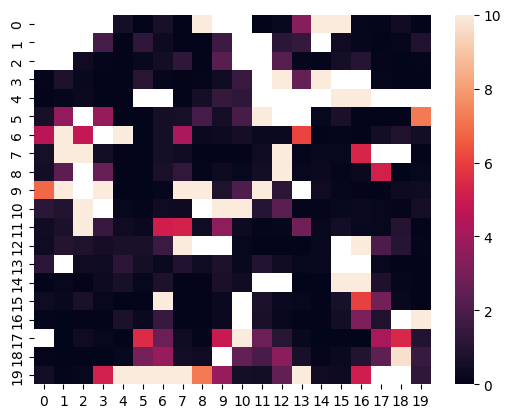

In [ ]:
sns.heatmap(heatmap_diff,vmin=0,vmax=10)

In [ ]:
heatmap_decay_streched_decay_firsthalfdata[7,7]

0.4576339923524512

Text(0, 0.5, 'Frequency')

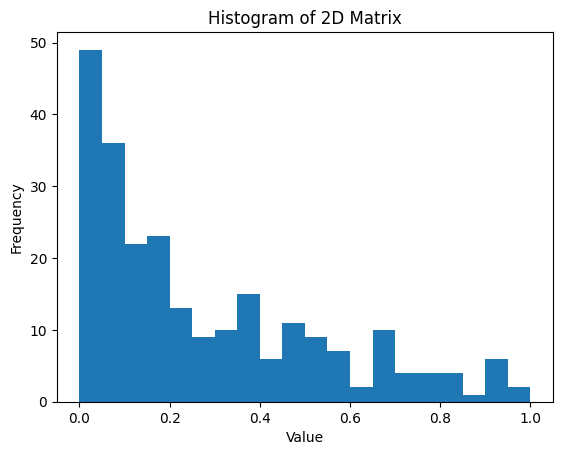

In [ ]:
plt.hist(heatmap_diff.flatten(),bins=20,range=(0,1))
plt.title("Histogram of 2D Matrix")
plt.xlabel("Value")
plt.ylabel("Frequency")

## Extrapolate the zeroth point, calculate the diff with the true zeroth point

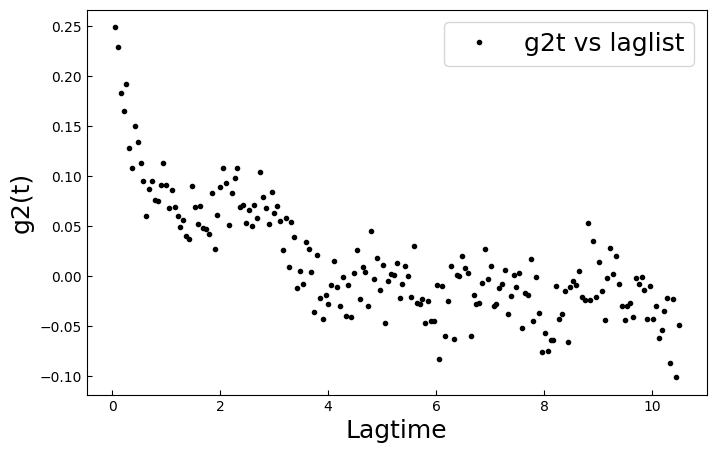

In [18]:
laglist_g2t=range(0,200,1)
px=[155,88]
g2t=compute_g2t_wo_kernel(px,laglist_g2t)
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[1:],g2t[1:],'k.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
#plt.yscale('log')
plt.tick_params(direction='in')

0.2454444524342505
y = -1.75396 * x + -0.81540


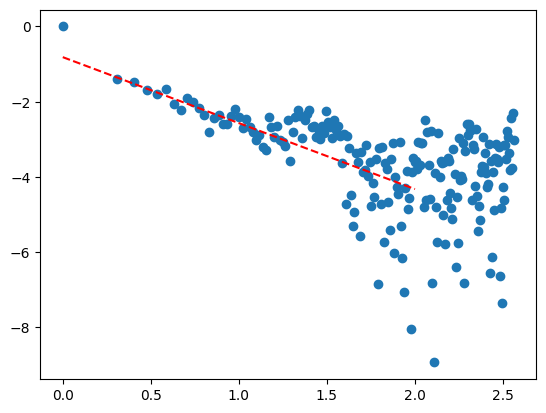

In [19]:
plateau=0
startidx_fast=1
endidx_fast=7
temp=fit_streched_exponential_decay_plot(plateau,g2t,laglist_g2t,startidx_fast,endidx_fast)

In [20]:
temp

(0.5701397070269697, -1.7539560701964867, -0.8154013635748643)

In [21]:
zeroth=np.exp(math.log(g2t[1])-temp[1]*(framespeed)**(0.4))
difference=g2t[0]-zeroth
print(zeroth)
print(g2t[0])
print(difference)

0.4277015892790294
1.0
0.5722984107209705


In [ ]:
heatmap_decay_streched_decay = np.zeros((20, 20))
zeroth_diff=np.zeros((20,20))
for y in range(0,20,1):
    for x in range(0,20,1):
        px=[y,x]
        print(px)
        g2t=compute_g2t_wo_kernel([80+y,80+x],laglist_g2t)
        plateau=0
        startidx_fast=1
        endidx_fast=7
        temp=fit_streched_exponential_decay(plateau,g2t,laglist_g2t,startidx_fast,endidx_fast)
        inverse_power=1/0.4
        heatmap_decay_streched_decay[px[0],px[1]]=temp**inverse_power
    
        zeroth=np.exp(math.log(g2t[1])-temp*(framespeed)**(0.4))
        difference=g2t[0]-zeroth
        zeroth_diff[px[0],px[1]]=difference


<AxesSubplot: >

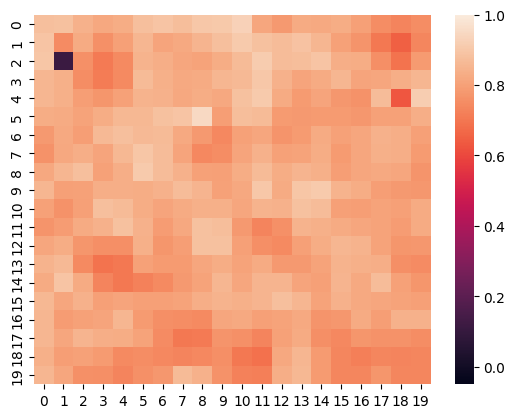

In [23]:
sns.heatmap(zeroth_diff,vmin=-0.05,vmax=1)

Text(0, 0.5, 'Frequency')

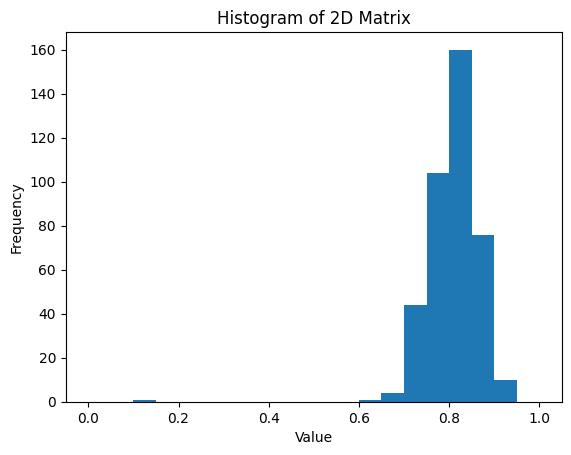

In [24]:
plt.hist(zeroth_diff.flatten(),bins=20,range=(0,1))
plt.title("Histogram of 2D Matrix")
plt.xlabel("Value")
plt.ylabel("Frequency")